In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, average_precision_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.ensemble import EasyEnsembleClassifier

from pyod.models.xgbod import XGBOD
from joblib import dump, load

import matplotlib.pyplot as plt


# Data preparation

In [2]:
# Load the data
data = pd.read_csv('../data/train_test_set.csv')
data = pd.get_dummies(data, columns = ['main_industry', 'year'])

X_train = data[data['train'] == 1].drop(columns=['cik', 'sic', 'sic_description', 'filedate', 'accession_num',
       'primary_doc', 'filelink', 'bank_status', 'train'])
X_test = data[data['train'] == 0].drop(columns=['cik', 'sic', 'sic_description', 'filedate', 'accession_num',
       'primary_doc', 'filelink', 'bank_status', 'train'])
y_train = data[data['train']==1]['bank_status']
y_test = data[data['train']==0]['bank_status']


In [3]:
# Standardization for numerical features 
scaler = StandardScaler().fit(X_train.iloc[:, 0:23])
scaled_terms_train = pd.DataFrame(scaler.transform(X_train.iloc[:, 0:23]), columns = X_train.columns[0:23])
X_num_train = pd.concat([scaled_terms_train, X_train.iloc[:,28:].reset_index(drop = True)], axis = 1)
scaled_terms_test = pd.DataFrame(scaler.transform(X_test.iloc[:, 0:23]), columns = X_test.columns[0:23])
X_num_test = pd.concat([scaled_terms_test, X_test.iloc[:,28:].reset_index(drop = True)], axis = 1)

In [4]:
# Load topic distribution and word embeddings
with open("../res/lsa.npy", "rb") as f:
    X_lsa_train = np.load(f)
    X_lsa_test = np.load(f)

with open("../res/bert.npy", "rb") as f:
    X_bert_train = np.load(f)
    X_bert_test = np.load(f)

In [5]:
X_sent_train = X_train.sentiment
X_sent_test = X_test.sentiment

In [6]:
# Generate data with different feature combinations
X_numsenti_train = np.hstack([X_num_train.to_numpy(), X_sent_train.to_numpy().reshape((-1, 1))])
X_numsenti_test = np.hstack([X_num_test.to_numpy(), X_sent_test.to_numpy().reshape((-1, 1))])
X_numlsa_train = np.hstack([X_num_train.to_numpy(), X_lsa_train])
X_numlsa_test = np.hstack([X_num_test.to_numpy(), X_lsa_test])
X_numbert_train = np.hstack([X_num_train.to_numpy(), X_bert_train])
X_numbert_test = np.hstack([X_num_test.to_numpy(), X_bert_test])
X_all_train = np.hstack([X_num_train.to_numpy(), X_lsa_train, X_bert_train, X_sent_train.to_numpy().reshape((-1, 1))])
X_all_test = np.hstack([X_num_test.to_numpy(), X_lsa_test, X_bert_test, X_sent_test.to_numpy().reshape((-1, 1))])

# Model fit

In [7]:
# Model evaluation
def measure(clf, X_train, y_train, X_test, y_test):
    y_pred_test = clf.predict(X_test)
    y_pred_prob_test = clf.predict_proba(X_test)[:,1]
    y_pred_train = clf.predict(X_train)
    y_pred_prob_train = clf.predict_proba(X_train)[:,1]

    print(classification_report(y_train, y_pred_train))
    print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

    print(classification_report(y_test, y_pred_test))
    print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

In [8]:
# Fit the XGBOD model
def fit_xgbod(X_train, y_train, X_test, y_test, load_path=None, save_path=None):
    if load_path:
        clf = load(load_path)
    else:
        clf = XGBOD(random_state=42)
        clf.fit(X_train, y_train)
    y_train_scores = clf.decision_scores_
    y_test_scores = clf.decision_function(X_test)
    if save_path:
        dump(clf, save_path)
    print(f"PR AUC on train set:{average_precision_score(y_train, y_train_scores)}")
    print(f"PR AUC on test set:{average_precision_score(y_test, y_test_scores)}")

In [9]:
# Fit all the models
def fit_all(X_train, y_train, X_test, y_test, load_path=None, save_path=None):
    print("="*20+"logistic regression"+"="*20)
    lr = LogisticRegression(
        max_iter = int(1e6),
        tol = 1e-6, 
        fit_intercept = False, 
        class_weight='balanced', 
        random_state=42,
        )
    lr.fit(X_train, y_train)
    measure(lr, X_train, y_train, X_test, y_test)
    
    print("="*20+"SVM"+"="*20)
    svm = SVC(class_weight = 'balanced', random_state = 42, probability=True, kernel="rbf", gamma="scale")
    svm.fit(X_train, y_train)
    measure(svm, X_train, y_train, X_test, y_test)

    print("="*20+"Decision Tree"+"="*20)
    tree = DecisionTreeClassifier(class_weight = 'balanced', random_state = 42)
    tree.fit(X_train, y_train)
    measure(tree, X_train, y_train, X_test, y_test)

    print("="*20+"Easy Ensemble"+"="*20)
    eec = EasyEnsembleClassifier(random_state=42, estimator=RandomForestClassifier(), n_estimators=20)
    eec.fit(X_train, y_train)
    measure(eec, X_train, y_train, X_test, y_test)

    print("="*20+"XGBOD"+"="*20)
    if load_path:
        clf = load(load_path)
    else:
        clf = XGBOD(random_state=42)
        clf.fit(X_train, y_train)
    y_train_scores = clf.decision_scores_
    y_test_scores = clf.decision_function(X_test)
    if save_path:
        dump(clf, save_path)
    print(f"PR AUC on train set:{average_precision_score(y_train, y_train_scores)}")
    print(f"PR AUC on test set:{average_precision_score(y_test, y_test_scores)}")


## Numerical features only

In [10]:
fit_all(X_num_train, y_train, X_num_test, y_test)

====================logistic regression====================
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      7025
           1       0.03      0.95      0.07        40

    accuracy                           0.85      7065
   macro avg       0.52      0.90      0.49      7065
weighted avg       0.99      0.85      0.91      7065

Train average precision: 0.051595569012316364
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2330
           1       0.05      0.69      0.09        26

    accuracy                           0.85      2356
   macro avg       0.52      0.77      0.50      2356
weighted avg       0.99      0.85      0.91      2356

Test average precision: 0.06921478857138398
====================SVM====================
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      7025
           1       0.06      1.00      0.11

/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/pyod/models/base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:24:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


PR AUC on train set:0.989292786502539
PR AUC on test set:0.37057125187594436


## Numerical features + sentiment scores

In [11]:
fit_all(X_numsenti_train, y_train, X_numsenti_test, y_test)

====================logistic regression====================
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      7025
           1       0.03      0.95      0.07        40

    accuracy                           0.85      7065
   macro avg       0.52      0.90      0.49      7065
weighted avg       0.99      0.85      0.91      7065

Train average precision: 0.05100537089528237
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2330
           1       0.05      0.73      0.10        26

    accuracy                           0.85      2356
   macro avg       0.52      0.79      0.51      2356
weighted avg       0.99      0.85      0.91      2356

Test average precision: 0.0700993973977713
====================SVM====================
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      7025
           1       0.06      1.00      0.11  

/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/pyod/models/base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:26:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


PR AUC on train set:0.9836518533616058
PR AUC on test set:0.38430904813049777


## Numerical features + topic distribution

In [11]:
fit_all(X_numlsa_train, y_train, X_numlsa_test, y_test, save_path="../res/numlsa.joblib") 

====================logistic regression====================
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      7025
           1       0.09      1.00      0.17        40

    accuracy                           0.95      7065
   macro avg       0.55      0.97      0.57      7065
weighted avg       0.99      0.95      0.97      7065

Train average precision: 0.2870463483727455
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      2330
           1       0.10      0.58      0.17        26

    accuracy                           0.94      2356
   macro avg       0.55      0.76      0.57      2356
weighted avg       0.99      0.94      0.96      2356

Test average precision: 0.19737365729485093
====================SVM====================
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      7025
           1       0.11      1.00      0.20  

/Users/yimeng_yin/anaconda3/lib/python3.11/site-packages/pyod/models/base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/Users/yimeng_yin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


PR AUC on train set:0.9963952761173408
PR AUC on test set:0.5983131426579215


## Numerical features + word embeddings

In [13]:
fit_all(X_numbert_train, y_train, X_numbert_test, y_test, save_path="../res/numbert.joblib") 

====================logistic regression====================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7025
           1       0.82      1.00      0.90        40

    accuracy                           1.00      7065
   macro avg       0.91      1.00      0.95      7065
weighted avg       1.00      1.00      1.00      7065

Train average precision: 0.9815198768603048
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2330
           1       0.62      0.31      0.41        26

    accuracy                           0.99      2356
   macro avg       0.80      0.65      0.70      2356
weighted avg       0.99      0.99      0.99      2356

Test average precision: 0.23819223918358684
====================SVM====================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7025
           1       0.75      1.00      0.86  

/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/pyod/models/base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:32:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


PR AUC on train set:0.9963952761173407
PR AUC on test set:0.22297754715783152


## Numerical features + sentiment scores + topic distribution + word embeddings

In [14]:
fit_all(X_all_train, y_train, X_all_test, y_test, save_path="../res/all.joblib") 

====================logistic regression====================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7025
           1       0.83      1.00      0.91        40

    accuracy                           1.00      7065
   macro avg       0.92      1.00      0.95      7065
weighted avg       1.00      1.00      1.00      7065

Train average precision: 0.9851680046720357
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2330
           1       0.62      0.31      0.41        26

    accuracy                           0.99      2356
   macro avg       0.80      0.65      0.70      2356
weighted avg       0.99      0.99      0.99      2356

Test average precision: 0.23010375779410494
====================SVM====================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7025
           1       0.75      1.00      0.86  

/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/pyod/models/base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:36:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


PR AUC on train set:0.9963952761173408
PR AUC on test set:0.20294233915279603


## Random guess model

In [147]:
lr = LogisticRegression(
    max_iter = int(1e6),
    tol = 1e-6, 
    fit_intercept = False, 
    class_weight='balanced', 
    random_state=42,
    )
lr.fit(X_all_train, y_train)
y_pred = lr.predict(X_all_test)
print(confusion_matrix(y_test, y_pred))

[[2325    5]
 [  18    8]]


In [149]:
y_train.value_counts()

bank_status
0    7025
1      40
Name: count, dtype: int64

In [71]:
np.random.seed(42)
def random_guess(y_train, y_test):
    threshold = len(y_train[y_train == 1]) / len(y_train[y_train == 0])
    y_scores = np.random.uniform(size=(len(y_test), 1))
    y_pred = (y_scores < threshold)
    print(classification_report(y_test, y_pred))
    print(average_precision_score(y_test, y_pred))


In [72]:
random_guess(y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2330
           1       0.00      0.00      0.00        26

    accuracy                           0.99      2356
   macro avg       0.49      0.50      0.50      2356
weighted avg       0.98      0.99      0.98      2356

0.011035653650254669


# Model interpretation

In [12]:
clf = load("../res/numlsa.joblib")

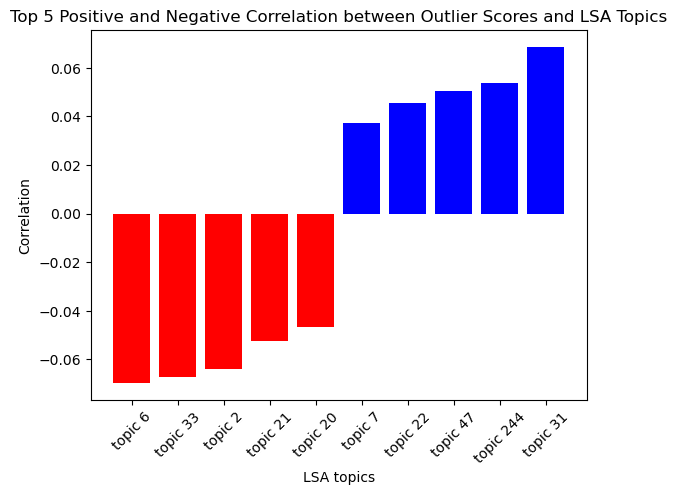

In [67]:
X_numlsa_all = np.vstack([X_numlsa_train, X_numlsa_test])
y_pred = clf.decision_function(X_numlsa_test)
y_score = np.concatenate([clf.decision_scores_, y_pred])


res = []
for i in range(300):
    res.append(np.corrcoef(y_score, X_numlsa_all[:, i+47].astype("float"))[0,1])

# Convert the list to a NumPy array for easier manipulation
arr_values = np.array(res)

# Get the indices that would sort the array
sorted_indices = np.argsort(arr_values)

# Get the indices of the 5 smallest values
min_indices = sorted_indices[:5]
# Get the indices of the 5 largest values (reversed to get descending order)
max_indices = sorted_indices[-6:-1]
indices = np.concatenate([min_indices, max_indices])

plt.bar(np.arange(5), arr_values[min_indices], color="red")
plt.bar(np.arange(5, 10), arr_values[max_indices], color="blue")
plt.xticks(np.arange(10), [f"topic {i + 1}" for i in indices], rotation = 45)

plt.xlabel("LSA topics")
plt.ylabel("Correlation")
plt.title("Top 5 Positive and Negative Correlation between Outlier Scores and LSA Topics")
plt.show()

In [42]:
eec = EasyEnsembleClassifier(random_state=42, estimator=RandomForestClassifier(), n_estimators=20)
eec.fit(X_num_train, y_train)
measure(eec, X_num_train, y_train, X_num_test, y_test)

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      7025
           1       0.03      1.00      0.06        40

    accuracy                           0.82      7065
   macro avg       0.52      0.91      0.48      7065
weighted avg       0.99      0.82      0.90      7065

Train average precision: 0.7948702412558267
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      2330
           1       0.05      0.85      0.09        26

    accuracy                           0.82      2356
   macro avg       0.52      0.83      0.50      2356
weighted avg       0.99      0.82      0.89      2356

Test average precision: 0.4239947505685783


In [43]:
ests = eec.estimators_

In [44]:
importances = []
for i in range(20):
    importances.append(ests[i][1].feature_importances_)


In [45]:
importances = np.vstack(importances)
impo = np.mean(importances, axis=0)

In [46]:
num_idx =  np.array(X_train.columns[0:23].to_list() + X_train.columns[28:].to_list())

In [51]:
num_idx[9] = 'NetIncome'

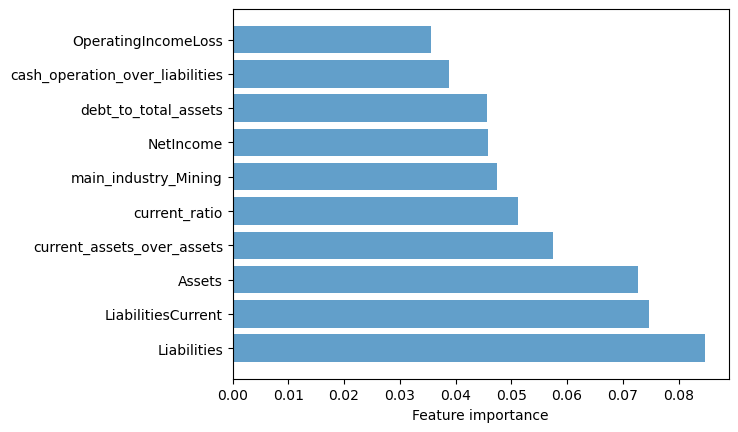

In [52]:
indices = np.argsort(impo)[::-1][:10]
plt.barh(range(len(indices)), impo[indices], alpha = 0.7)
plt.yticks(range(len(indices)), num_idx[indices])
plt.xlabel("Feature importance")
plt.show()